In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd

summary = pd.read_csv('/content/drive/MyDrive/ML_Project/Abstractive_Text_Summarization/news_summary.csv',
                      encoding='iso-8859-1')
raw = pd.read_csv('/content/drive/MyDrive/ML_Project/Abstractive_Text_Summarization/news_summary_more.csv',
                  encoding='iso-8859-1')


In [7]:
pre1 = raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()

# To increase the intake of possible text values to build a reliable model
pre2['text'] = pre2['author'].str.cat(pre2['date'
        ].str.cat(pre2['read_more'].str.cat(pre2['text'
        ].str.cat(pre2['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'], pre2['headlines']],
                           ignore_index=True)

In [8]:
pre.head(2)


,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...


In [9]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):
    # print(column)
    # print('============')
    for row in column:
        # print(0, row)
        row = re.sub("(\\t)", " ", str(row)).lower()
        # print(1, row)
        row = re.sub("(\\r)", " ", str(row)).lower()
        # print(2, row)
        row = re.sub("(\\n)", " ", str(row)).lower()
        # print(3, row)
        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()
        # print(4, row)
        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()
        # print(5, row)
        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()
        # print(6, row)
        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()
        # print(7, row)
        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()
        # print(8,row)
        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()
        # print(9, row)
        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()
        # print(10, row)
        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()
        # print(11, row)
        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()
        # print(12, row)
        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()
        # print(13, row)
        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()
        # print(14, row)
        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
            # print(15, row)
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()
        # print(16, row)
        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()
        # print(17, row)

        yield row

In [10]:
print(pre['text'][0])

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


In [12]:
processed_text = text_strip(pre['text'][:10000])
print(len(pre['text']))
processed_summary = text_strip(pre['summary'][:10000])
print(len(pre['summary']))

102915
102915


In [13]:
print(processed_text)

<generator object text_strip at 0x7f1bdcb84bd0>


In [14]:
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=5000)]

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['ner', 'parser'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


In [15]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [16]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [17]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

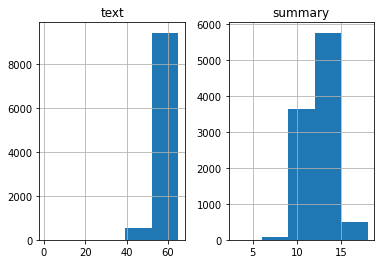

In [27]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent1,sent2 in zip(pre['cleaned_text'],pre['cleaned_summary']):
  if isinstance(sent1, str) and isinstance(sent2, str):
    text_count.append(len(sent1.split()))
    summary_count.append(len(sent2.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [29]:
# Check how much % of text have 0-100 words
cnt = 0
for i in pre['cleaned_text']:
    if isinstance(i, str) and len(i.split()) <= 100:
        cnt = cnt + 1
print(cnt / len(pre['cleaned_text']))

0.09716756546664723


In [30]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 100
max_summary_len = 15

In [34]:
# Select the Summaries and Text which fall below max length 

import numpy as np

cleaned_text = np.array(pre['cleaned_text'])
cleaned_summary= np.array(pre['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if isinstance(cleaned_text[i], str) and isinstance(cleaned_summary[i], str) and len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...


In [35]:
# Add sostok and eostok

post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


In [57]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"][:1000]),
    np.array(post_pre["summary"][:1000]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [58]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [59]:
thresh = 3

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  66.82279469164715


In [60]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 2976


In [61]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 3

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 79.7799174690509
Size of vocabulary in Y = 736


In [63]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [64]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

# TRAINING PART

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

## Network arch

In [66]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 200)     595200      ['input_3[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 100, 300),   601200      ['embedding_2[0][0]']            
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                            

### define early stopping

In [67]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

### Fit the model

In [68]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
8/8 [==============================] - 116s 9s/step - loss: 4.7856 - val_loss: 3.3045
Epoch 2/50
8/8 [==============================] - 68s 8s/step - loss: 3.4643 - val_loss: 3.0406
Epoch 3/50
8/8 [==============================] - 70s 9s/step - loss: 3.3531 - val_loss: 2.9732
Epoch 4/50
8/8 [==============================] - 68s 8s/step - loss: 3.1782 - val_loss: 2.8843
Epoch 5/50
8/8 [==============================] - 68s 8s/step - loss: 3.5106 - val_loss: 3.0252
Epoch 6/50
8/8 [==============================] - 66s 8s/step - loss: 3.0751 - val_loss: 2.8177
Epoch 7/50
8/8 [==============================] - 70s 9s/step - loss: 2.9507 - val_loss: 2.7374
Epoch 8/50
8/8 [==============================] - 66s 8s/step - loss: 2.9152 - val_loss: 2.6273
Epoch 9/50
8/8 [==============================] - 72s 9s/step - loss: 2.8454 - val_loss: 2.6361
Epoch 10/50
8/8 [==============================] - 70s 9s/step - loss: 2.8155 - val_loss: 2.5936
Epoch 11/50
8/8 [=====================

### loss history

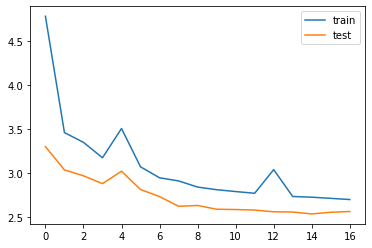

In [69]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Generating Predictions

In [70]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index


In [71]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [72]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [73]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [74]:
for i in range(0, 19):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           max_text_len)))
    print('\n')

Review: after priyanka gandhi vadra entered active politics the shiv sena on friday said priyanka will as the queen if she plays her cards well it added priyanka an to her grandmother late prime minister indira gandhi in looks and manner of speaking the congress will benefit in the hindi 
Original summary: start if priyanka her well she ll as queen sena end 
1/1 [==============================] - 0s 27ms/step
Predicted summary:  start to to to to end


Review: punjabi singer actor virk will be making his bollywood debut with khan directorial 83 which is based on india first world cup victory in virk will play former fast bowler singh sandhu in the film that stars ranveer singh in the role of former captain kapil sandhu is also ranveer for the film 
Original summary: start singer to play ex pacer in end 
1/1 [==============================] - 0s 28ms/step
Predicted summary:  start to to to to end


Review: airtel on wednesday said that qatar wealth fund qatar investment authority will 2

In [75]:


# serialize model to JSON
model_json = model.to_json()
with open("summary_news.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("summary_news.h5")
print("Saved model to disk")



Saved model to disk
